In [1]:
import random, string

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import TextVectorization, Embedding

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

2.9.1


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH = KaggleDatasets().get_gcs_path()
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync

## 1. Load data

In [3]:
data = pd.read_csv("./data/dataset.csv")
data.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [4]:
data.shape

(200000, 2)

## 2. Preprocess data

In [5]:
# 0 -> False, 1 -> True (for humor)
le = LabelEncoder()
data["humor"] = le.fit_transform(data["humor"].astype(str))

In [6]:
data.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


In [7]:
data.humor.value_counts()

0    100000
1    100000
Name: humor, dtype: int64

In [8]:
X = data.text.values
y = data.humor.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train[:2], len(X_train), y_train[:2], len(y_train)

(array(['10 brands that will disappear in 2014: 24/7 wall st.',
        'The richest black man in nyc has got to be duane reade.'],
       dtype=object),
 180000,
 array([0, 1]),
 180000)

## 3. Getting a baseline model

### Model 0: Baseline

In [10]:
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(
    X_train,
    y_train
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [11]:
model_0.score(X_test, y_test)

0.91445

In [12]:
baseline_preds = model_0.predict(X_test)

In [13]:
def model_metrics(y_true, y_pred):
    model_acc = accuracy_score(y_true, y_pred) * 100
    model_prec, model_rec, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_acc,
        "precision": model_prec,
        "recall": model_rec,
        "f1": model_f1
    }
    return model_results

In [14]:
baseline_results = model_metrics(y_test, baseline_preds)
baseline_results

{'accuracy': 91.445,
 'precision': 0.9153000713862554,
 'recall': 0.91445,
 'f1': 0.9144175815657278}

## 4. Preparing for deep sequence modeling

In [15]:
sent_lens = [len(sentence.split()) for sentence in X_train]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

11.98461111111111

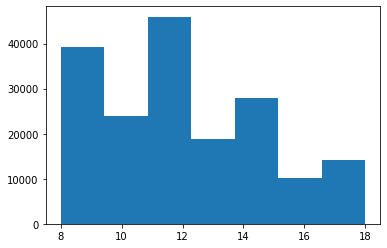

In [16]:
plt.hist(sent_lens, bins=7);

In [17]:
output_seq_length = int(np.percentile(sent_lens, 95))
output_seq_length

17

In [18]:
max(sent_lens)

18

#### `TextVectorizer`

In [19]:
max_tokens = 65000

text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_length
)

text_vectorizer.adapt(X_train)

2022-05-25 16:21:11.838152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
target_sentence = random.choice(X_train)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
Virtual superpowers could make you do good in real life, study finds

Length of text: 12

Vectorized text:
[[ 6094 15466   111    67     5    13   100     6   238   104   240   416
      0     0     0     0     0]]


In [21]:
humor_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(humor_text_vocab)}")
print(f"Most common words in the vocabulary: {humor_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {humor_text_vocab[-5:]}")

Number of words in vocabulary: 65000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'a', 'to']
Least common words in the vocabulary: ['brucevelt', 'brucea', 'bru', 'brthday', 'brrrrrrrriba']


In [22]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 65000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 17,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### `Embedding`

In [23]:
token_embed = Embedding(
    input_dim=len(humor_text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
Virtual superpowers could make you do good in real life, study finds

Sentence after vectorization (before embedding):
[[ 6094 15466   111    67     5    13   100     6   238   104   240   416
      0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02536832  0.02826187  0.03626345 ...  0.0355028  -0.02683876
    0.02497131]
  [-0.00142113  0.01918516 -0.02710426 ...  0.03066741  0.01004207
    0.01613237]
  [-0.00475992 -0.01215066  0.04598602 ...  0.00257257 -0.00935303
    0.0485402 ]
  ...
  [ 0.01409564  0.03339401  0.00057713 ... -0.03916335 -0.01525529
    0.01326329]
  [ 0.01409564  0.03339401  0.00057713 ... -0.03916335 -0.01525529
    0.01326329]
  [ 0.01409564  0.03339401  0.00057713 ... -0.03916335 -0.01525529
    0.01326329]]]

Embedded sentence shape: (1, 17, 128)


## 5. Create datasets

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(AUTOTUNE)

train_ds, val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## 6. Deep sequence modeling

### Model 1: Conv1D

In [25]:
inputs = layers.Input(shape=(1,), dtype="string")
text_vectors = text_vectorizer(inputs)
token_embedding = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 17)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 17, 128)          8320000   
                                                                 
 conv1d (Conv1D)             (None, 17, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65    

In [26]:
model_1_history = model_1.fit(
    train_ds,
    steps_per_epoch=int(len(train_ds)*1),
    epochs=3,
    validation_data=val_ds,
    validation_steps=int(len(val_ds)*1)
)

Epoch 1/3
5625/5625 [==============================] - 517s 92ms/step - loss: 0.1599 - accuracy: 0.9370 - val_loss: 0.1263 - val_accuracy: 0.9502
Epoch 2/3
5625/5625 [==============================] - 541s 96ms/step - loss: 0.0915 - accuracy: 0.9658 - val_loss: 0.1351 - val_accuracy: 0.9506
Epoch 3/3
5625/5625 [==============================] - 539s 96ms/step - loss: 0.0530 - accuracy: 0.9813 - val_loss: 0.1789 - val_accuracy: 0.9432


In [27]:
def compare_baseline(baseline_results, new_model_results):
    for k, v in baseline_results.items():
        print(f"Baseline {k}: {v:.2f}, New {k}: {new_model_results[k]:.2f}, Difference: {new_model_results[k]-v:.2f}")

In [28]:
model_1_pred_probs = model_1.predict(val_ds)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_results = model_metrics(y_test, model_1_preds)
compare_baseline(baseline_results, model_1_results)

625/625 [==============================] - 2s 2ms/step
Baseline accuracy: 91.44, New accuracy: 94.32, Difference: 2.88
Baseline precision: 0.92, New precision: 0.94, Difference: 0.03
Baseline recall: 0.91, New recall: 0.94, Difference: 0.03
Baseline f1: 0.91, New f1: 0.94, Difference: 0.03


### Model 2: USE

In [29]:
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder"
)

In [30]:
random_training_sentence = random.choice(X_train)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
I fucked a sarcastic girl. she loved it.

Sentence after embedding:
[-0.04821153  0.04435393 -0.01559508 -0.07059026 -0.04568106 -0.07324086
 -0.05257398 -0.07105169  0.05831163  0.03567677  0.04093827 -0.04784641
 -0.06829762  0.04652815 -0.01915524 -0.09809903  0.04405495  0.05036256
 -0.05080822 -0.07192779 -0.04252034  0.0152081   0.01252204  0.06299751
 -0.02515407  0.00050796  0.05117004  0.04789493  0.02166951  0.05074413] (truncated output)...

Length of sentence embedding:
512


In [31]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [32]:
model_2_history = model_2.fit(
    train_ds,
    steps_per_epoch=int(len(val_ds)*1),
    epochs=3,
    validation_data=val_ds,
    validation_steps=int(len(val_ds)*1)
)

Epoch 1/3
625/625 [==============================] - 9s 11ms/step - loss: 0.2210 - accuracy: 0.9208 - val_loss: 0.1704 - val_accuracy: 0.9345
Epoch 2/3
625/625 [==============================] - 7s 11ms/step - loss: 0.1661 - accuracy: 0.9370 - val_loss: 0.1631 - val_accuracy: 0.9370
Epoch 3/3
625/625 [==============================] - 7s 11ms/step - loss: 0.1553 - accuracy: 0.9402 - val_loss: 0.1594 - val_accuracy: 0.9394


In [33]:
model_2_pred_probs = model_2.predict(val_ds)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = model_metrics(y_test, model_2_preds)
compare_baseline(baseline_results, model_2_results)

625/625 [==============================] - 3s 5ms/step
Baseline accuracy: 91.44, New accuracy: 93.94, Difference: 2.49
Baseline precision: 0.92, New precision: 0.94, Difference: 0.02
Baseline recall: 0.91, New recall: 0.94, Difference: 0.02
Baseline f1: 0.91, New f1: 0.94, Difference: 0.02


### Model 2: Conv1D + Character-level embedding

In [34]:
def split_chars(text):
    return " ".join(list(text))

split_chars(random_training_sentence)

'I   f u c k e d   a   s a r c a s t i c   g i r l .   s h e   l o v e d   i t .'

In [35]:
%%time
X_train_chars = [split_chars(sentence) for sentence in X_train]
X_test_chars = [split_chars(sentence) for sentence in X_test]
print(X_train_chars[0])

1 0   b r a n d s   t h a t   w i l l   d i s a p p e a r   i n   2 0 1 4 :   2 4 / 7   w a l l   s t .
CPU times: user 347 ms, sys: 12.3 ms, total: 359 ms
Wall time: 358 ms


In [36]:
# Average character length per sentence
char_lens = [len(sentence) for sentence in X_train]
mean_char_len = np.mean(char_lens)
mean_char_len

67.46562777777778

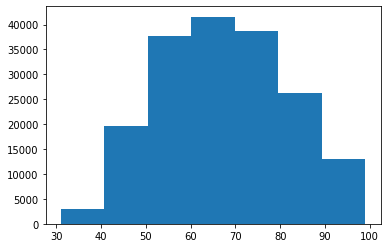

In [37]:
plt.hist(char_lens, bins=7);

In [38]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

92

#### `TextVectorization` character-level

In [39]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # alphabet + space + OOV token

char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    standardize="lower_and_strip_punctuation",
    name="char_vectorizer"
)

char_vectorizer.adapt(X_train_chars)

In [41]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters: ['', '[UNK]', 'e', 'a', 't']
5 least common characters: ['ν', 'κ', 'ι', 'ε', '™']


In [42]:
# Test out character vectorizer
random_train_chars = random.choice(X_train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
B l o s s o m   i n t o   s p r i n g   w i t h   t h i s   t r a n s c e n d e n t a l   e x p e r i m e n t   i n   q u e e r   c o m m u n i t y

Length of chars: 65

Vectorized chars:
[[21 11  5  7  7  5 15  6  8  4  5  7 19  9  6  8 18 17  6  4 10  4 10  6
   7  4  9  3  8  7 14  2  8 12  2  8  4  3 11  2 25 19  2  9  6 15  2  8
   4  6  8 30 13  2  2  9 14  5 15 15 13  8  6  4 16  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Length of vectorized chars: 92


#### `Embedding` character-level

In [43]:
char_embed = Embedding(
    input_dim=NUM_CHAR_TOKENS,
    output_dim=25,
    mask_zero=False,
    name="char_embed"
)

print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
B l o s s o m   i n t o   s p r i n g   w i t h   t h i s   t r a n s c e n d e n t a l   e x p e r i m e n t   i n   q u e e r   c o m m u n i t y

Embedded chars (after vectorization and embedding):
[[[-0.04278633  0.02350708 -0.01890649 ... -0.03685812 -0.04887281
   -0.00060499]
  [-0.04699808  0.01771511  0.00022664 ...  0.02017239  0.00736298
   -0.03385614]
  [-0.00902503 -0.04746861 -0.01788958 ...  0.00759411  0.00025726
    0.04213256]
  ...
  [-0.0253758   0.04179157 -0.03488462 ... -0.01314817 -0.00655448
   -0.02383124]
  [-0.0253758   0.04179157 -0.03488462 ... -0.01314817 -0.00655448
   -0.02383124]
  [-0.0253758   0.04179157 -0.03488462 ... -0.01314817 -0.00655448
   -0.02383124]]]

Character embedding shape: (1, 92, 25)


#### Create character-level dataset

In [44]:
train_char_ds = tf.data.Dataset.from_tensor_slices((X_train_chars, y_train)).batch(32).prefetch(AUTOTUNE)
val_char_ds = tf.data.Dataset.from_tensor_slices((X_test_chars, y_test)).batch(32).prefetch(AUTOTUNE)

train_char_ds, val_char_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#### Modeling

In [45]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]
)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 92)               0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 92, 25)            1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 64)            8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 1)                 65  

In [46]:
model_3_history = model_3.fit(
    train_char_ds,
    steps_per_epoch=int(len(train_char_ds)*1),
    epochs=3,
    validation_data=val_char_ds,
    validation_steps=int(len(val_char_ds)*1)
)

Epoch 1/3
5625/5625 [==============================] - 26s 4ms/step - loss: 0.3403 - accuracy: 0.8535 - precision: 0.8654 - recall: 0.8374 - auc: 0.9293 - val_loss: 0.2716 - val_accuracy: 0.8898 - val_precision: 0.8816 - val_recall: 0.8991 - val_auc: 0.9555
Epoch 2/3
5625/5625 [==============================] - 24s 4ms/step - loss: 0.2547 - accuracy: 0.8959 - precision: 0.9036 - recall: 0.8865 - auc: 0.9601 - val_loss: 0.2488 - val_accuracy: 0.8982 - val_precision: 0.8891 - val_recall: 0.9087 - val_auc: 0.9629
Epoch 3/3
5625/5625 [==============================] - 25s 4ms/step - loss: 0.2351 - accuracy: 0.9043 - precision: 0.9107 - recall: 0.8967 - auc: 0.9660 - val_loss: 0.2422 - val_accuracy: 0.9010 - val_precision: 0.8879 - val_recall: 0.9166 - val_auc: 0.9654


In [47]:
model_3_pred_probs = model_3.predict(val_char_ds)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_results = model_metrics(y_test, model_3_preds)
compare_baseline(baseline_results, model_3_results)

625/625 [==============================] - 1s 1ms/step
Baseline accuracy: 91.44, New accuracy: 90.10, Difference: -1.34
Baseline precision: 0.92, New precision: 0.90, Difference: -0.01
Baseline recall: 0.91, New recall: 0.90, Difference: -0.01
Baseline f1: 0.91, New f1: 0.90, Difference: -0.01


### Model 4: USE + Character-level embeddings

In [48]:
# 1. Token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

# 2. Char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concat
token_char_concat = layers.Concatenate(name="token_char_hybrid")(
    [token_model.output, char_model.output]
)

# 4. Dropout layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(1, activation="sigmoid")(final_dropout)

# 5. Create model
model_4 = tf.keras.Model(
    [token_model.input, char_model.input],
    output_layer,
    name="model_4_token_and_char_embeddings"
)

model_4.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]
)

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 92)          0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [49]:
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#### Create hybrid dataset

In [50]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((X_train, X_train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_char_token_ds = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((X_test, X_test_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
val_char_token_ds = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(AUTOTUNE)

train_char_token_ds, val_char_token_ds

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [51]:
model_4_history = model_4.fit(
    train_char_token_ds,
    steps_per_epoch=int(len(train_char_token_ds)*1),
    epochs=3,
    validation_data=val_char_token_ds,
    validation_steps=int(len(val_char_token_ds)*1)
)

Epoch 1/3
5625/5625 [==============================] - 193s 34ms/step - loss: 0.1620 - accuracy: 0.9381 - precision_1: 0.9409 - recall_1: 0.9350 - auc_1: 0.9834 - val_loss: 0.1331 - val_accuracy: 0.9489 - val_precision_1: 0.9523 - val_recall_1: 0.9446 - val_auc_1: 0.9886
Epoch 2/3
5625/5625 [==============================] - 180s 32ms/step - loss: 0.1353 - accuracy: 0.9487 - precision_1: 0.9520 - recall_1: 0.9451 - auc_1: 0.9883 - val_loss: 0.1223 - val_accuracy: 0.9543 - val_precision_1: 0.9548 - val_recall_1: 0.9532 - val_auc_1: 0.9903
Epoch 3/3
5625/5625 [==============================] - 190s 34ms/step - loss: 0.1243 - accuracy: 0.9530 - precision_1: 0.9556 - recall_1: 0.9503 - auc_1: 0.9899 - val_loss: 0.1186 - val_accuracy: 0.9548 - val_precision_1: 0.9602 - val_recall_1: 0.9484 - val_auc_1: 0.9910


In [52]:
model_4_pred_probs = model_4.predict(val_char_token_ds)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = model_metrics(y_test, model_4_preds)
compare_baseline(baseline_results, model_4_results)

625/625 [==============================] - 7s 10ms/step
Baseline accuracy: 91.44, New accuracy: 95.48, Difference: 4.04
Baseline precision: 0.92, New precision: 0.95, Difference: 0.04
Baseline recall: 0.91, New recall: 0.95, Difference: 0.04
Baseline f1: 0.91, New f1: 0.95, Difference: 0.04


## 7. Compare model results

In [53]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,91.445,0.915300,0.91445,0.914418
custom_token_embed_conv1d,94.320,0.943705,0.94320,0.943189
pretrained_token_embed,93.935,0.939447,0.93935,0.939349
custom_char_embed_conv1d,90.100,0.901433,0.90100,0.900983
hybrid_char_token_embed,95.480,0.954865,0.95480,0.954797


In [54]:
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

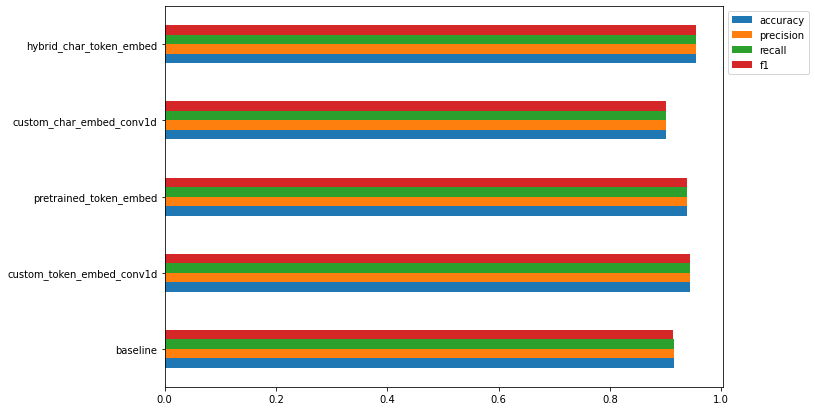

In [55]:
all_model_results.plot(kind="barh", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

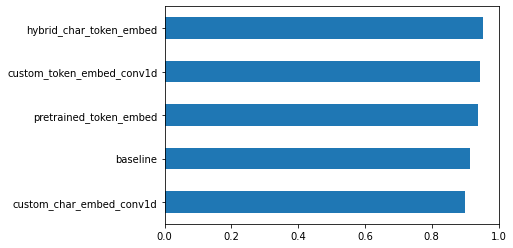

In [56]:
all_model_results.f1.sort_values(ascending=True).plot.barh();

## 8. Save best performing model

In [57]:
# Save in SavedModel format
model_4.save("hybrid_model")

INFO:tensorflow:Assets written to: hybrid_model/assets


INFO:tensorflow:Assets written to: hybrid_model/assets


In [58]:
import shutil
shutil.make_archive("hybrid_model", 'zip', "hybrid_model")

'/Users/roderikmogot/humor-prediction/hybrid_model.zip'